In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from pathlib import Path
import matplotlib.pyplot as plt

In [20]:
# Defines some variables
INPUT = Path("features_gB4.csv")
OUT_TRAIN = Path("train_reduced_gB4.csv")
OUT_VAL = Path("validation_reduced_gB4.csv")
OUT_TEST = Path("test_reduced_gB4.csv")
RANDOM_STATE = 42

# Loads initial data
df = pd.read_csv(INPUT)

# Extract 'band_gap' column as target Y
Y = df['band_gap']

# Keep numeric features only (drop non-numeric columns)
X = df.select_dtypes(include=[np.number])

# Remove 'band_gap' from features
X = X.drop(columns=['band_gap'])

# Split 70% train, 20% val, 10% test (features and target together)
X_train, X_temp = train_test_split(X, test_size=0.30, random_state=RANDOM_STATE, shuffle=True)
# From the 30% temp, split so test is 1/3 of temp => 10% of tota
X_val, X_test = train_test_split(X_temp, test_size=1/3, random_state=RANDOM_STATE, shuffle=True)

Y_train, Y_temp = train_test_split(Y, test_size=0.30, random_state=RANDOM_STATE, shuffle=True)
Y_val, Y_test = train_test_split(Y_temp, test_size=1/3, random_state=RANDOM_STATE, shuffle=True)

pd.DataFrame(Y_train, columns=['band_gap']).to_csv('train_target_gB4.csv', index=False)
pd.DataFrame(Y_val, columns=['band_gap']).to_csv('validation_target_gB4.csv', index=False)
pd.DataFrame(Y_test, columns=['band_gap']).to_csv('test_target_gB4.csv', index=False)

In [21]:
# Scales data for standardization and writes it back to the same files

# Fits scaler on features data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Saves the scaled features data and writes to CSVs (features data)
pd.DataFrame(X_train_scaled, columns=X_train.columns).to_csv('train_reduced_gB4.csv', index=False)
pd.DataFrame(X_val_scaled, columns=X_val.columns).to_csv('validation_reduced_gB4.csv', index=False)
pd.DataFrame(X_test_scaled, columns=X_test.columns).to_csv('test_reduced_gB4.csv', index=False)

# Fits scaler on target data
scaler_y = StandardScaler()
Y_train_scaled = scaler_y.fit_transform(Y_train.values.reshape(-1, 1))
Y_val_scaled = scaler_y.transform(Y_val.values.reshape(-1, 1))
Y_test_scaled = scaler_y.transform(Y_test.values.reshape(-1, 1))

#  Saves the scaled features data and writes to CSVs (target data)
pd.DataFrame(Y_train_scaled, columns=['band_gap']).to_csv('train_target_gB4.csv', index=False)
pd.DataFrame(Y_val_scaled, columns=['band_gap']).to_csv('validation_target_gB4.csv', index=False)
pd.DataFrame(Y_test_scaled, columns=['band_gap']).to_csv('test_target_gB4.csv', index=False)

Robust elbow point is at component 7 (eigenvalue: 0.7907)


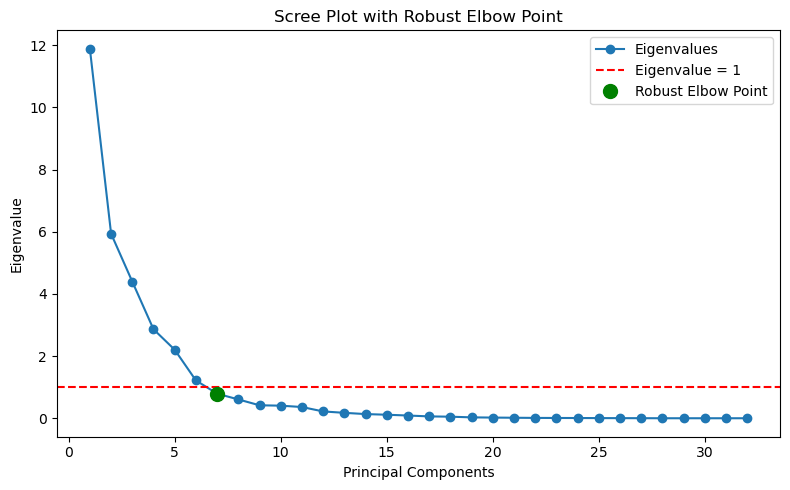

In [22]:
# Scree plot

# Apply PCA with no dimensionality reduction to get all eigenvalues
pca_full = PCA()
pca_full.fit(X_train_scaled)
eigenvalues = pca_full.explained_variance_

# Robust elbow (knee) detection using the distance to line method
def find_elbow_knee(eigenvalues):
    n_points = len(eigenvalues)
    all_coords = np.vstack((np.arange(n_points), eigenvalues)).T
    first_point = all_coords[0]
    last_point = all_coords[-1]
    line_vec = last_point - first_point
    line_vec_norm = line_vec / np.sqrt(np.sum(line_vec**2))
    vec_from_first = all_coords - first_point
    scalar_product = np.sum(vec_from_first * np.tile(line_vec_norm, (n_points, 1)), axis=1)
    vec_on_line = np.outer(scalar_product, line_vec_norm)
    distance_to_line = np.sqrt(np.sum((vec_from_first - vec_on_line) ** 2, axis=1))
    elbow_idx = np.argmax(distance_to_line)
    return elbow_idx

elbow_idx = find_elbow_knee(eigenvalues)
print(f"Robust elbow point is at component {elbow_idx + 1} (eigenvalue: {eigenvalues[elbow_idx]:.4f})")

# Plot scree plot with robust elbow point highlighted
plt.figure(figsize=(8, 5))
plt.plot(np.arange(1, len(eigenvalues) + 1), eigenvalues, marker='o', label='Eigenvalues')
plt.axhline(1, color='r', linestyle='--', label='Eigenvalue = 1')
plt.plot(elbow_idx + 1, eigenvalues[elbow_idx], 'go', markersize=10, label='Robust Elbow Point')
plt.xlabel('Principal Components')
plt.ylabel('Eigenvalue')
plt.title('Scree Plot with Robust Elbow Point')
plt.legend()
plt.tight_layout()
plt.show()

# Apply the best variance ratio as found by the scree plot
# Convert the elbow eigenvalue to the expected explained variance ratio
PCA_VARIANCE = np.sum(eigenvalues[:elbow_idx + 1]) / np.sum(eigenvalues)

In [23]:
# Fit PCA on training set only
pca = PCA(n_components=PCA_VARIANCE, svd_solver="full")
pca.fit(X_train_scaled)

# Transform datasets
X_train_red = pca.transform(X_train_scaled)
X_val_red = pca.transform(X_val_scaled)
X_test_red = pca.transform(X_test_scaled)

# Write reduced datasets to CSVs
n_comp = X_train_red.shape[1]
cols = [f"PC{i+1}" for i in range(n_comp)]
pd.DataFrame(X_train_red, columns=cols).to_csv(OUT_TRAIN, index=False)
pd.DataFrame(X_val_red, columns=cols).to_csv(OUT_VAL, index=False)
pd.DataFrame(X_test_red, columns=cols).to_csv(OUT_TEST, index=False)